# Imports

In [3]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
import random

# Creating the dataset

In [4]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [5]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.04341 sec'

In [6]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00024 sec'

Creating vectors with a purpose-built library such as pytorch allows us to perform vector operations much more efficiently

# Normal Distribution

In [7]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

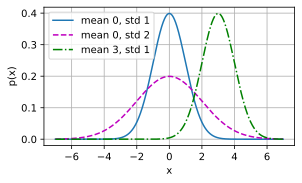

In [8]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# Synthetic Data Creation

In [9]:
# Sample Data
X = torch.tensor([[1.0], [2.0], [3.0], [4.0]], dtype=torch.float32)
y = torch.tensor([[2.0], [4.0], [6.0], [8.0]], dtype=torch.float32)

In [36]:
class LinearRegressionSyntheticData:
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000, batch_size=32):
        self.w = w
        self.b = b
        self.num_train = num_train
        self.num_val = num_val
        n = num_train + num_val
        self.X = torch.randn((n, len(w)))
        noise = torch.randn(n, 1) * noise
        self.y = torch.matmul(self.X, self.w.reshape(-1, 1)) + self.b + noise
        self.batch_size = batch_size
    
    def train_dataloader(self, train):
        if train:
            indices = list(range(0, self.num_train))
            # The examples are read in random order
            random.shuffle(indices)
        else:
            indices = list(range(self.num_train, self.num_train+self.num_val))
        for i in range(0, len(indices), self.batch_size):
            batch_indices = torch.tensor(indices[i: i+self.batch_size])
            yield self.X[batch_indices], self.y[batch_indices]

In [37]:
data = LinearRegressionSyntheticData(w=torch.tensor([2, -3.4]), b=4.2)

In [38]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tensor([-0.8905, -0.6059]) 
label: tensor([4.4824])


In [39]:
X, y = next(iter(data.train_dataloader(train=True)))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


# Linear Regression

In [40]:
class SGD:
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [67]:
class LinearLayer:
    def __init__(self, input_size, output_size):
        # Initialize weights and biases randomly
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))

    def forward(self, x):
        # Forward pass: x * W + b
        self.x = x  # Store input for backpropagation
        return np.dot(x, self.weights) + self.biases

    def backward(self, grad_output, learning_rate):
        # Backpropagation: compute gradients and update weights/biases
        grad_weights = np.dot(self.x.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        grad_input = np.dot(grad_output, self.weights.T)

        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases
        return grad_input

    def mse_loss(self, y_true, y_pred):
       return np.mean((y_true - y_pred) ** 2)

    def mse_loss_derivative(self, y_true, y_pred):
       return 2 * (y_pred - y_true) / y_true.size
    
    def sgd_optimizer(self, layer, grad_output, learning_rate):
       return layer.backward(grad_output, learning_rate)


In [68]:
class NeuralNetwork:
    def __init__(self, input_size, output_size):
        self.linear = LinearLayer(input_size, output_size)

    def forward(self, x):
        return self.linear.forward(x)

    def backward(self, grad_output, learning_rate):
        return self.linear.sgd_optimizer(self.linear, grad_output, learning_rate)

    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            y_pred = self.forward(x_train)
            loss = self.linear.mse_loss(y_train, y_pred)
            grad_output = self.linear.mse_loss_derivative(y_train, y_pred)
            self.backward(grad_output, learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {loss}")


In [69]:
model = NeuralNetwork(input_size=2, output_size=1)
data = LinearRegressionSyntheticData(w=torch.tensor([2, -3.4]), b=4.2)
# Prepare training data from the synthetic dataset
X_train = data.X[:data.num_train].numpy()
y_train = data.y[:data.num_train].numpy()

# Train the model
model.train(X_train, y_train, epochs=1000, learning_rate=0.01)

Epoch: 0, Loss: 31.43378244960877
Epoch: 100, Loss: 0.6970635582868285
Epoch: 200, Loss: 0.015754060983415565
Epoch: 300, Loss: 0.0004603972018700133
Epoch: 400, Loss: 0.00011378616172462699
Epoch: 500, Loss: 0.00010587435205038327
Epoch: 600, Loss: 0.00010569280561632296
Epoch: 700, Loss: 0.00010568862389582596
Epoch: 800, Loss: 0.00010568852730950245
Epoch: 900, Loss: 0.00010568852507422319


In [ ]:
# Create a sample test tensor for prediction
test_x = np.array([[0.5, -1.2]], dtype=np.float32)
prediction = model.forward(test_x)
print("Prediction for test_x:", prediction)

Prediction for test_x: [[9.28009084]]


# Linear Regression with Weight Decay

In [ ]:
class LinearRegression:
    def __init__(self, input_size, output_size, weight_decay=0.0):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        self.weight_decay = weight_decay

    def forward(self, x):
        self.x = x
        return np.dot(x, self.weights) + self.biases

    def mse_loss(self, y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        l2 = self.weight_decay * np.sum(self.weights ** 2)
        return mse + l2

    def mse_loss_derivative(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / y_true.size

    def backward(self, grad_output, learning_rate):
        grad_weights = np.dot(self.x.T, grad_output) + 2 * self.weight_decay * self.weights
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        self.weights -= learning_rate * grad_weights
        self.biases -= learning_rate * grad_biases

    def train(self, x_train, y_train, epochs, learning_rate, batch_size=32):
        n = x_train.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n)
            np.random.shuffle(indices)
            for start in range(0, n, batch_size):
                end = start + batch_size
                batch_idx = indices[start:end]
                xb = x_train[batch_idx]
                yb = y_train[batch_idx]
                y_pred = self.forward(xb)
                loss = self.mse_loss(yb, y_pred)
                grad_output = self.mse_loss_derivative(yb, y_pred)
                self.backward(grad_output, learning_rate)
            if (epoch + 1) % 2 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


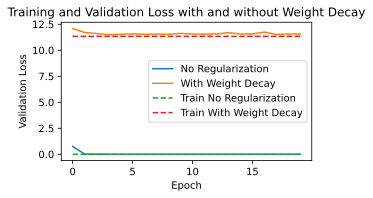

In [73]:
import matplotlib.pyplot as plt

# Prepare data from LinearRegressionSyntheticData
X_train = data.X[:data.num_train].numpy()
y_train = data.y[:data.num_train].numpy()
X_val = data.X[data.num_train:].numpy()
y_val = data.y[data.num_train:].numpy()

# Train without regularization
model_no_reg = LinearRegression(input_size=2, output_size=1, weight_decay=0.0)
losses_no_reg = []
for epoch in range(20):
    model_no_reg.train(X_train, y_train, epochs=1, learning_rate=0.03)
    y_pred = model_no_reg.forward(X_val)
    loss = model_no_reg.mse_loss(y_val, y_pred)
    losses_no_reg.append(loss)

# Train with regularization
model_reg = LinearRegression(input_size=2, output_size=1, weight_decay=3)
losses_reg = []
for epoch in range(20):
    model_reg.train(X_train, y_train, epochs=1, learning_rate=0.03)
    y_pred = model_reg.forward(X_val)
    loss = model_reg.mse_loss(y_val, y_pred)
    losses_reg.append(loss)

# Plot validation loss curves
plt.plot(losses_no_reg, label='No Regularization')
plt.plot(losses_reg, label='With Weight Decay')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Training and Validation Loss with and without Weight Decay')

# Calculate training losses for both models
train_losses_no_reg = []
train_losses_reg = []
for epoch in range(20):
    # No regularization
    y_pred_train_no_reg = model_no_reg.forward(X_train)
    train_loss_no_reg = model_no_reg.mse_loss(y_train, y_pred_train_no_reg)
    train_losses_no_reg.append(train_loss_no_reg)
    # With regularization
    y_pred_train_reg = model_reg.forward(X_train)
    train_loss_reg = model_reg.mse_loss(y_train, y_pred_train_reg)
    train_losses_reg.append(train_loss_reg)

# Plot training losses
plt.plot(train_losses_no_reg, '--', label='Train No Regularization')
plt.plot(train_losses_reg, '--', label='Train With Weight Decay')
plt.legend()
plt.show()